# **Irene Dovichi** 
## Midterm 1 - Assignment 5
Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the segments identified by NCUT and the ground truth horse semantic segmentation. Provide a table summarizing the average segmentation accuracy on all images, plus present 2 examples of images that are well-segmented (according to the above defined metric).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, graph, io
from skimage.metrics import structural_similarity
from skimage.filters import threshold_mean, threshold_otsu, threshold_yen
import os
import seaborn as sns
from tqdm import tqdm

## Dataset Loading
All the original images of the Weizmann Horse Database (link: www.kaggle.com/datasets/ztaihong/weizmann-horse-database/data) are saved in the list `images`. 

The corresponding masks are saved in the list `masks`.

In [2]:
path = './weizmann_horse_db/horse'
images = []
for file in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path, file)):
        images.append(io.imread(os.path.join(path, file)))

In [3]:
path = './weizmann_horse_db/mask'
masks = []
for file in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path, file)):
        masks.append(io.imread(os.path.join(path, file)))

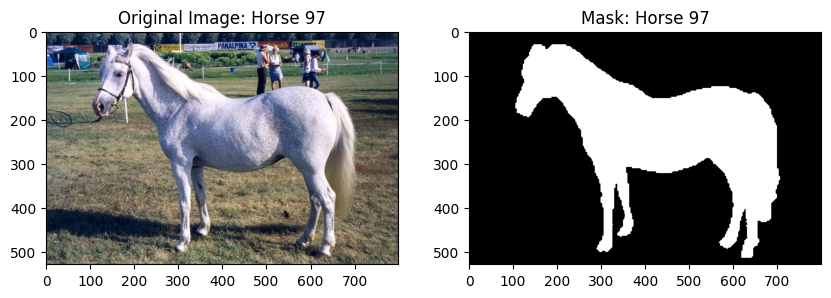

In [4]:
# print element m of `images` and the corresponding element of `masks`
m = 97

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(images[m])
plt.title(f'Original Image: Horse {m}')

plt.subplot(1, 2, 2)
plt.imshow(masks[m], cmap='gray')
plt.title(f'Mask: Horse {m}')
plt.show()

## Segmentation
The skimage implementation of SLIC algorithm was used to generate the superpixels of images. The parameters I focused on were:
- `compactness`, for which I tried the values: 
- `sigma`, for which I tried:
- `n_segments`, for which I tried: 

The best parameter configuration was chosen on the basis of the results obtained comparing the processed images and the masks.

I also tried the zero parameter version SLICO.

In [4]:
# convert images to grayscale
gray_images = [color.rgb2gray(img) for img in images]

In [6]:
# compactness parameters
compactness = [5, 10, 20]

# sigma parameters
sigma = [0, 1]

# number of segments
n_segments = [75, 100, 500]

I performed the grid search on half of the instances of the dataset (randomly chosen), since it is time consuming.

In [7]:
len(images)

327

In [8]:
# select k random images 
k = 164
np.random.seed(42)
random_indexes = np.random.choice(len(images), k, replace=False)
random_images = []
gray_random_images = []
random_masks = []
for i in random_indexes:
    random_images.append(images[i])
    gray_random_images.append(gray_images[i])
    random_masks.append(masks[i])


apply segmentation to colored images

In [9]:
segmentation_results = []

# apply segmentation and ncut
with tqdm(total=16*k, desc='loading', colour='yellow') as pbar:
    for i in range(len(random_images)): 
        image_results = []
        for c in compactness:
            for s in sigma:
                for n in n_segments:
                    # if c,s,n = 5,1,500 or 10,0,500 skip
                    if (c,s,n) == (5,1,500) or (c,s,n) == (10,0,500):
                        continue
                    segments = segmentation.slic(random_images[i], compactness=c, n_segments=n, sigma=s)
                    g = graph.rag_mean_color(random_images[i], segments, mode='similarity')
                    cut = graph.cut_normalized(segments, g)
                    # store results for this combination of parameters
                    image_results.append((c, s, n, segments, cut))
                    pbar.update(1)
        segmentation_results.append(image_results)

loading: 100%|██████████| 2624/2624 [50:58<00:00,  1.17s/it]  


In [10]:
# for example, the segmentation of the first image, for the first combination of parameters (c, s, n) is:
segmentation_results[0][0][3]

array([[ 1,  1,  1, ...,  8,  8,  8],
       [ 1,  1,  1, ...,  8,  8,  8],
       [ 1,  1,  1, ...,  8,  8,  8],
       ...,
       [51, 51, 51, ..., 50, 50, 50],
       [51, 51, 51, ..., 50, 50, 50],
       [51, 51, 51, ..., 50, 50, 50]])

In [ ]:
'''# we can also use average of the pixels (in the corresponding superpixel) to color the superpixel
colored = color.label2rgb(segmentation_results[0][0][3], random_images[0], kind='avg')
plt.imshow(colored)'''

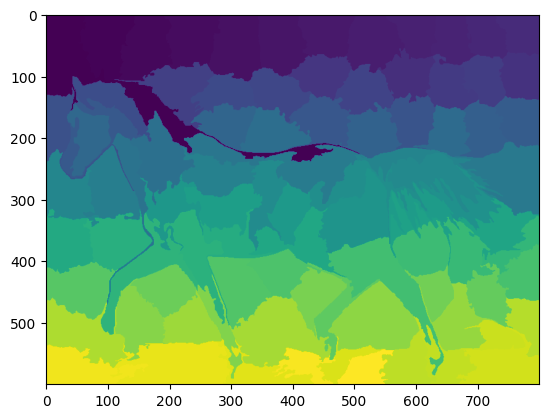

In [33]:
plt.imshow(segmentation_results[7][8][3])

Segmentation accuracy: now let's compare the segmented regions obtained from normalized cut with ground truth segmentation masks. 

The tried metrics are: 
- Intersection over Union $$IoU(A,B) = \frac{|A \cap B|}{|A \cup B|}$$ 
- Structural Similarity Index Measure (SSIM)

In [26]:
def IoU(segments, mask):
    intersection = np.logical_and(segments, mask)
    union = np.logical_or(segments, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

Since the comparison is done with the masks, which have only 2 colors, I decided to reduce the cut to a 2-colors image. So, I converted the multi-class segmentation result into a binary mask by thresholding the pixel values. 
1. first, use the labels to create the rgb image
2. switch to grayscale images so it's uniform for all of them
3. use a threshold to split in two: otsu, yen or mean

Let's see on a chosen horse the result of each step, before applying it to all the `random_images`.

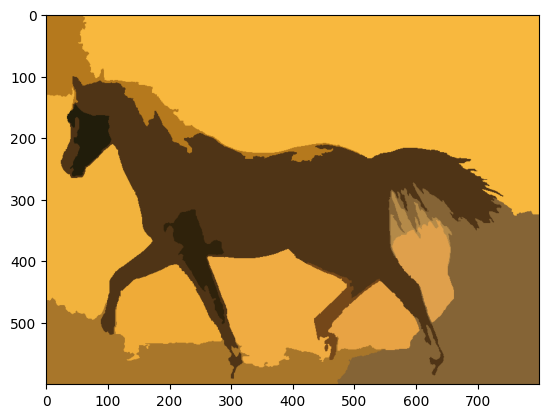

In [128]:
# step 1
ncolored = color.label2rgb(segmentation_results[7][8][4], random_images[7], kind='avg')
plt.imshow(ncolored)

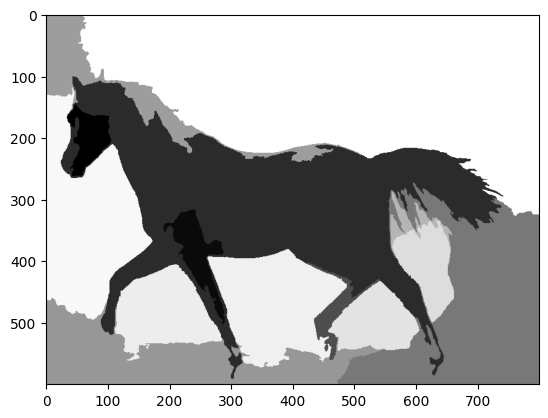

In [123]:
# step 2
gray_image = color.rgb2gray(ncolored)
plt.imshow(gray_image, cmap='gray')

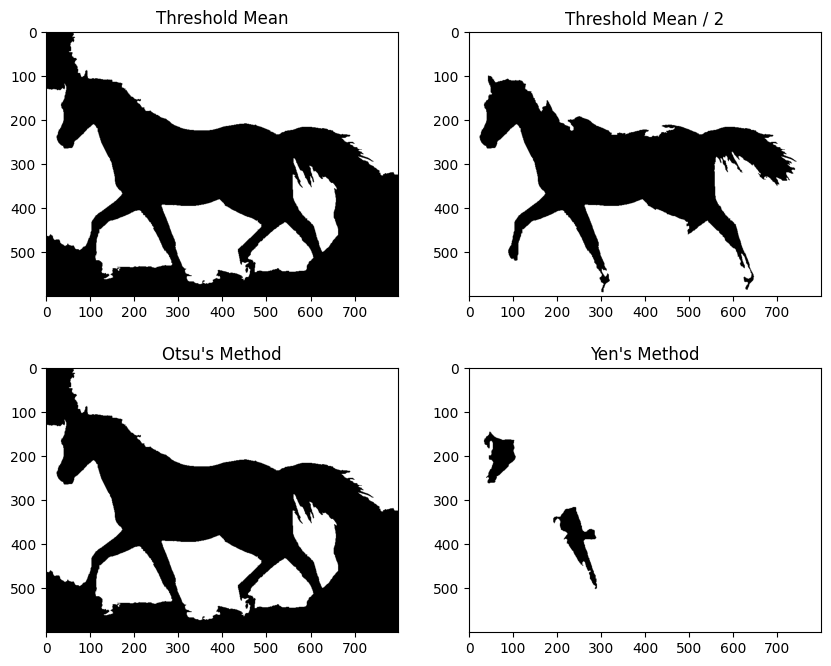

In [93]:
# step 3

# use threshold_mean to create a binary mask
thresh = threshold_mean(gray_image)
thresh_image = gray_image > thresh

# use threshold_mean divided by 2 to create a binary mask
thresh2 = threshold_mean(gray_image)/2
thresh_image2 = gray_image > thresh2

# use otsu's method
thresh_otsu = threshold_otsu(gray_image)
thresh_image_otsu = gray_image > thresh_otsu

# try yen's method
thresh_yen = threshold_yen(gray_image)
thresh_image_yen = gray_image > thresh_yen

# plot the masks
plt.figure(figsize=(10,8))
plt.subplot(2, 2, 1)
plt.imshow(thresh_image, cmap='gray')
plt.title('Threshold Mean')

plt.subplot(2, 2, 2)
plt.imshow(thresh_image2, cmap='gray')
plt.title('Threshold Mean / 2')

plt.subplot(2, 2, 3)
plt.imshow(thresh_image_otsu, cmap='gray')
plt.title("Otsu's Method")

plt.subplot(2, 2, 4)
plt.imshow(thresh_image_yen, cmap='gray')
plt.title("Yen's Method")
plt.show()

In [96]:
iou = max(IoU(thresh_image2, random_masks[7]), IoU(1-thresh_image2, random_masks[7]))
iou

0.8006614839061648

In [101]:
ssim = max(
    structural_similarity(thresh_image2, random_masks[7], data_range=1),
    structural_similarity(1-thresh_image2, random_masks[7], data_range=1)
    )
ssim

0.895240846968187

I decided to try both the threshold mean and the threshold mean divided by 2.

In [104]:
# store in a dictionary the iou and ssim scores for each parameter combination using threshold_mean
iou_scores = {}
ssim_scores = {}

for config in range(len(segmentation_results[0])):
    iou_scores[config] = []
    ssim_scores[config] = []
    for i in range(len(random_images)):
        ncolored = color.label2rgb(segmentation_results[i][config][3], random_images[i], kind='avg')
        gray_image = color.rgb2gray(ncolored)
        thresh = threshold_mean(gray_image)
        thresh_image = gray_image > thresh
        iou = max(IoU(thresh_image, random_masks[i]), IoU(1-thresh_image, random_masks[i]))
        iou_scores[config].append(iou)
        ssim = max(
            structural_similarity(thresh_image, random_masks[i], data_range=1),
            structural_similarity(1-thresh_image, random_masks[i], data_range=1)
            )
        ssim_scores[config].append(ssim)

In [105]:
# store in a dictionary the iou and ssim scores for each parameter combination using threshold_mean/2
iou_scores2 = {}
ssim_scores2 = {}

for config in range(len(segmentation_results[0])):
    iou_scores2[config] = []
    ssim_scores2[config] = []
    for i in range(len(random_images)):
        ncolored = color.label2rgb(segmentation_results[i][config][3], random_images[i], kind='avg')
        gray_image = color.rgb2gray(ncolored)
        thresh = threshold_mean(gray_image)/2
        thresh_image = gray_image > thresh
        iou = max(IoU(thresh_image, random_masks[i]), IoU(1-thresh_image, random_masks[i]))
        iou_scores2[config].append(iou)
        ssim = max(
            structural_similarity(thresh_image, random_masks[i], data_range=1),
            structural_similarity(1-thresh_image, random_masks[i], data_range=1)
            )
        ssim_scores2[config].append(ssim)

In [110]:
# compute the mean iou and ssim scores for each parameter combination
mean_iou_scores = {}
mean_ssim_scores = {}
for config in range(len(segmentation_results[0])):
    mean_iou_scores[config] = np.mean(iou_scores[config])
    mean_ssim_scores[config] = np.mean(ssim_scores[config])

mean_iou_scores2 = {}
mean_ssim_scores2 = {}
for config in range(len(segmentation_results[0])):
    mean_iou_scores2[config] = np.mean(iou_scores2[config])
    mean_ssim_scores2[config] = np.mean(ssim_scores2[config])

In [116]:
# see the config corresponding to the max for the 4 dictionaries
print(f'Config with max IoU using threshold_mean: {max(mean_iou_scores, key=mean_iou_scores.get)}'
      f' with a score of {mean_iou_scores[max(mean_iou_scores, key=mean_iou_scores.get)]}')
print(f'Config with max SSIM using threshold_mean: {max(mean_ssim_scores, key=mean_ssim_scores.get)}'
        f' with a score of {mean_ssim_scores[max(mean_ssim_scores, key=mean_ssim_scores.get)]}')
print(f'Config with max IoU using threshold_mean/2: {max(mean_iou_scores2, key=mean_iou_scores2.get)}'
        f' with a score of {mean_iou_scores2[max(mean_iou_scores2, key=mean_iou_scores2.get)]}')
print(f'Config with max SSIM using threshold_mean/2: {max(mean_ssim_scores2, key=mean_ssim_scores2.get)}'
        f' with a score of {mean_ssim_scores2[max(mean_ssim_scores2, key=mean_ssim_scores2.get)]}')

Config with max IoU using threshold_mean: 12 with a score of 0.41290099584101636
Config with max SSIM using threshold_mean: 13 with a score of 0.6161164668701632
Config with max IoU using threshold_mean/2: 15 with a score of 0.4242547120992774
Config with max SSIM using threshold_mean/2: 13 with a score of 0.7162944734093615


In [126]:
# let's see which is the config 13
segmentation_results[0][13]

(20,
 1,
 75,
 array([[ 1,  1,  1, ..., 10, 10, 10],
        [ 1,  1,  1, ..., 10, 10, 10],
        [ 1,  1,  1, ..., 10, 10, 10],
        ...,
        [62, 62, 62, ..., 59, 59, 59],
        [62, 62, 62, ..., 59, 59, 59],
        [62, 62, 62, ..., 59, 59, 59]]),
 array([[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        ...,
        [43, 43, 43, ..., 43, 43, 43],
        [43, 43, 43, ..., 43, 43, 43],
        [43, 43, 43, ..., 43, 43, 43]]))

## NOW, choose parameters
on the basis of the performances, choose the parameters configuration: (c, s, n) = 20, 1, 75

In [130]:
# apply to all the images the best config
best_segmentations = []

# apply segmentation and ncut
with tqdm(total=len(images), desc='loading', colour='yellow') as pbar:
    for i in range(len(images)): 
        segments = segmentation.slic(images[i], compactness=20, n_segments=75, sigma=1)
        g = graph.rag_mean_color(images[i], segments, mode='similarity')
        cut = graph.cut_normalized(segments, g)
        # store results for this image
        best_segmentations.append((segments, cut))
        pbar.update(1)

loading: 100%|██████████| 327/327 [02:52<00:00,  1.90it/s]


In [151]:
# compute ssim score using threshold_mean/2 and threshold_mean for all the images
ssim = []
for i in range(len(images)):
    ncolored = color.label2rgb(best_segmentations[i][0], images[i], kind='avg')
    gray_image = color.rgb2gray(ncolored)
    thresh = threshold_mean(gray_image)/2
    thresh2 = threshold_mean(gray_image)
    thresh_image = gray_image > thresh
    thresh_image2 = gray_image > thresh2
    ssim_score = max(
        structural_similarity(thresh_image, masks[i], data_range=1),
        structural_similarity(1-thresh_image, masks[i], data_range=1),
        structural_similarity(thresh_image2, masks[i], data_range=1),
        structural_similarity(1-thresh_image2, masks[i], data_range=1)
        )
    ssim.append(ssim_score)

In [152]:
# print the mean ssim score, and the 2 images with the lowest and highest ssim score
print(f'Mean SSIM score: {np.mean(ssim)}')
print(f'Lowest SSIM score: {min(ssim)}')
print(f'Highest SSIM score: {max(ssim)}')

Mean SSIM score: 0.7270921994051983
Lowest SSIM score: 0.4262151941404842
Highest SSIM score: 0.9585141928148654


In [153]:
# get the indexes of the two lowest and two highest ssim scores
copy_ssim = ssim.copy()
copy_ssim.sort()
lowest = copy_ssim[:2]
highest = copy_ssim[-2:]
print(lowest, highest)

[0.4262151941404842, 0.4297243759765616] [0.945059994587134, 0.9585141928148654]


In [154]:
ssim.index(lowest[0]), ssim.index(lowest[1]), ssim.index(highest[0]), ssim.index(highest[1])

(265, 190, 124, 295)

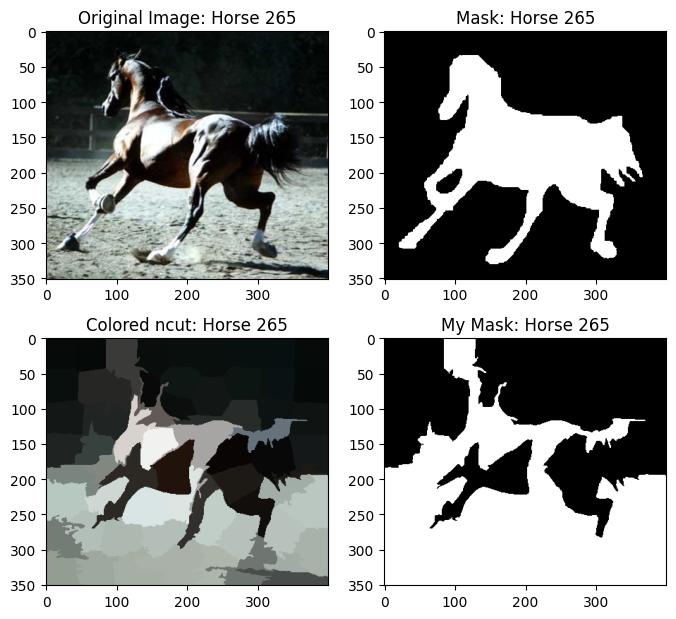

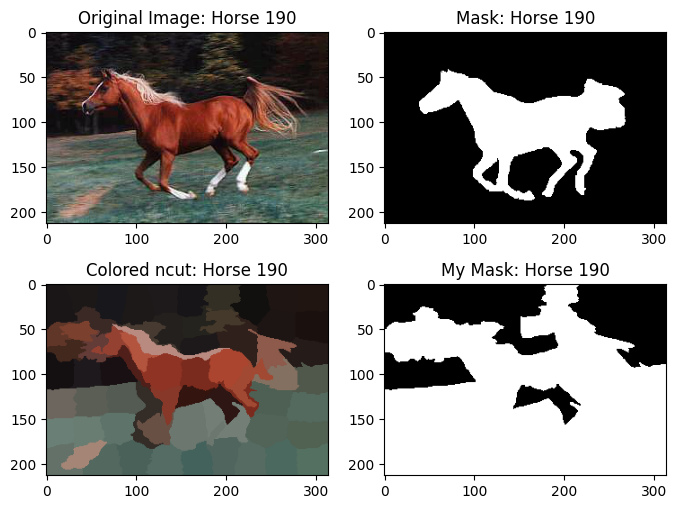

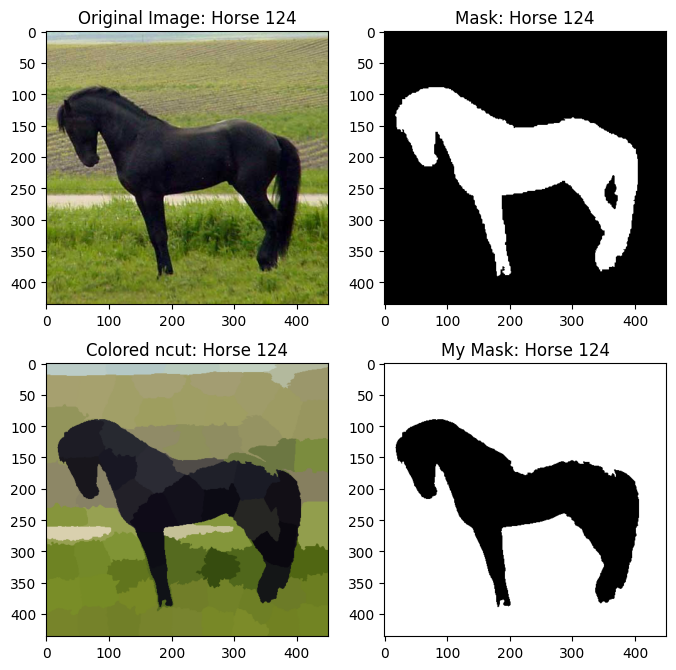

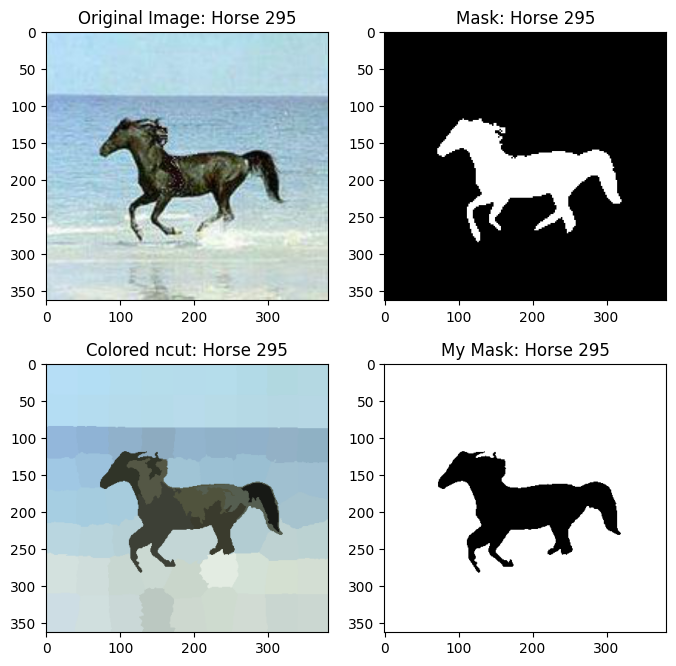

In [178]:
indexes = [ssim.index(lowest[0]), ssim.index(lowest[1]), ssim.index(highest[0]), ssim.index(highest[1])]

for i in indexes:
    if i == ssim.index(lowest[0]):
        plt.figure(figsize=(8,7.3))
    elif i == ssim.index(lowest[1]):
        plt.figure(figsize=(8,6))
    else:
        plt.figure(figsize=(8,7.9))
    plt.subplot(2, 2, 1)
    plt.imshow(images[i])
    plt.title(f'Original Image: Horse {i}')

    plt.subplot(2, 2, 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title(f'Mask: Horse {i}')

    ncolored = color.label2rgb(best_segmentations[i][0], images[i], kind='avg')
    gray_image = color.rgb2gray(ncolored)
    thresh = threshold_mean(gray_image)/2
    thresh2 = threshold_mean(gray_image)
    thresh_image = gray_image > thresh
    thresh_image2 = gray_image > thresh2
    a = structural_similarity(thresh_image, masks[i], data_range=1)
    b = structural_similarity(1-thresh_image, masks[i], data_range=1)
    c = structural_similarity(thresh_image2, masks[i], data_range=1)
    d = structural_similarity(1-thresh_image2, masks[i], data_range=1)
    m = max(a, b, c, d)
    if m == a or m==b:
        thresh_image = thresh_image
    else:
        thresh_image = thresh_image2
        
    plt.subplot(2, 2, 3)
    plt.imshow(ncolored)
    plt.title(f'Colored ncut: Horse {i}')

    plt.subplot(2, 2, 4)
    plt.imshow(thresh_image, cmap='gray')
    plt.title(f'My Mask: Horse {i}')
    plt.show()

Notice that, for the last two images, the mask is inverted wrt the thresholded image... that's why I considered the max over the two `structural_similarity` when calculating the ssim scores.

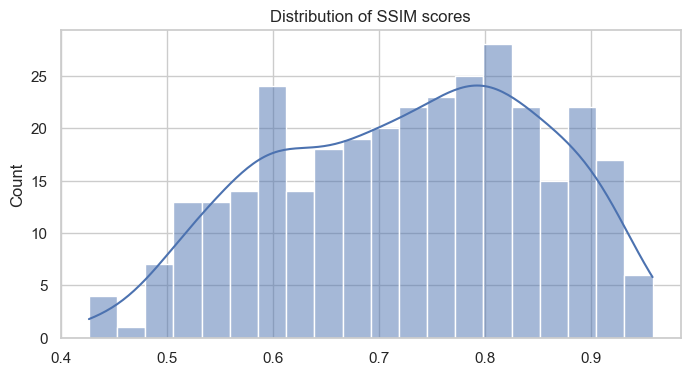

In [192]:
# plot the distribution of ssim scores with seaborn
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8,4))
sns.histplot(ssim, kde=True, bins=20)
plt.title('Distribution of SSIM scores')
plt.show()

### Zero parameters version
SLICO adaptively chooses the compactness parameter for each superpixel differently. This generates regular shaped superpixels in both textured and non textured regions alike.

In [16]:
segmentation_results = []

# apply segmentation and ncut
with tqdm(total=len(images), desc='loading', colour='yellow') as pbar:
    for i in range(len(images)): 
        image_results = []
        segments = segmentation.slic(images[i], slic_zero=True)
        g = graph.rag_mean_color(images[i], segments, mode='similarity')
        cut = graph.cut_normalized(segments, g)
        # store results for this combination of parameters
        image_results.append((segments, cut))
        pbar.update(1)
        segmentation_results.append(image_results)

loading: 100%|██████████| 327/327 [03:26<00:00,  1.58it/s]


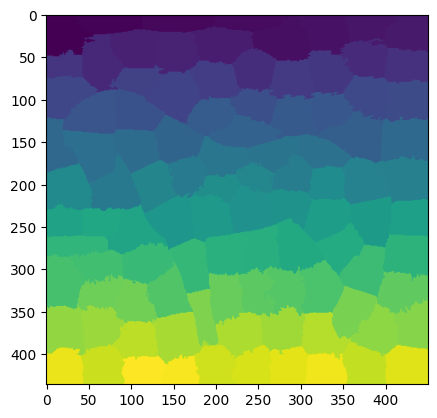

In [66]:
# segmentation for horse n. 125
plt.imshow(segmentation_results[124][0][0])

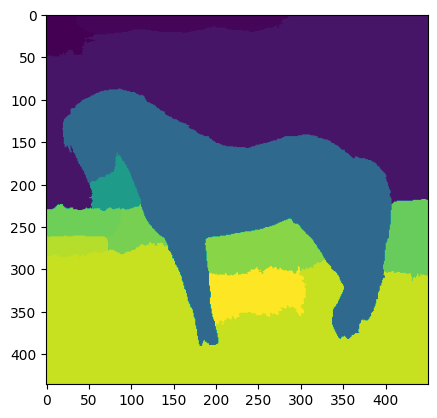

In [67]:
# cut for horse n. 125
plt.imshow(segmentation_results[124][0][1])

In [68]:
# compute ssim score using threshold_mean/2 and threshold_mean for all the images
ssim = []

for i in range(len(images)):
    ncolored = color.label2rgb(segmentation_results[i][0][0], images[i], kind='avg')
    gray_image = color.rgb2gray(ncolored)
    thresh = threshold_mean(gray_image)/2
    thresh2 = threshold_mean(gray_image)
    thresh_image = gray_image > thresh
    thresh_image2 = gray_image > thresh2
    ssim_score = max(
        structural_similarity(thresh_image, masks[i], data_range=1),
        structural_similarity(1-thresh_image, masks[i], data_range=1),
        structural_similarity(thresh_image2, masks[i], data_range=1),
        structural_similarity(1-thresh_image2, masks[i], data_range=1)
        )
    ssim.append(ssim_score)

In [69]:
# print the mean ssim score, and the 2 images with the lowest and highest ssim score
print(f'Mean SSIM score: {np.mean(ssim)}')
print(f'Lowest SSIM score: {min(ssim)}')
print(f'Highest SSIM score: {max(ssim)}')

Mean SSIM score: 0.7314376712134284
Lowest SSIM score: 0.4253023962821727
Highest SSIM score: 0.9521664271587108


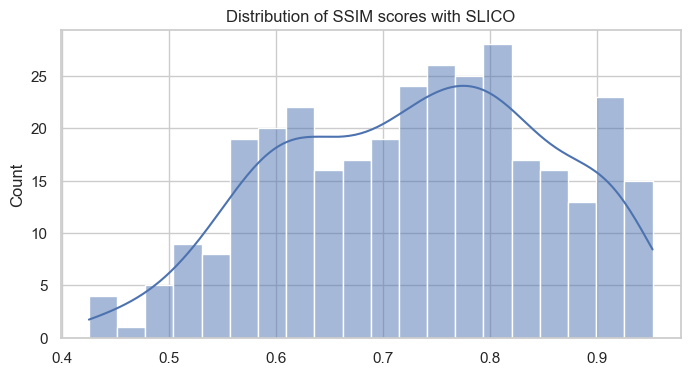

In [70]:
# plot the distribution of ssim scores with seaborn
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8,4))
sns.histplot(ssim, kde=True, bins=20)
plt.title('Distribution of SSIM scores with SLICO')
plt.show()

The results obtained are very similar to the ones of the configuration chosen with the grid search.

In [72]:
# get the indexes of the two lowest and two highest ssim scores
copy_ssim = ssim.copy()
copy_ssim.sort()
lowest = copy_ssim[:2]
highest = copy_ssim[-2:]

ssim.index(lowest[0]), ssim.index(lowest[1]), ssim.index(highest[0]), ssim.index(highest[1])

(11, 265, 122, 295)

Notice that the best horse obtained is the same both for SLIC and SLICO, and also the horse 265 is in both cases one of the worst.

## Valutation

In [ ]:
# for the chosen configuration of parameters, let's perform the segmentation and ncut algorithm on all the images

## Results & Analysis

In [ ]:
# summarizing table

## Personal Considerations

In [ ]:
# fun things, weak aspects, possible ways to enhance the analysis, etc.

# I also tried IoU metric, which qualitavely gives similar results to SSIM, but quantitavily gives lower values (true???)

# I also tried otsu and yen thresholding, but the results are not better than the mean thresholding

# i tried a coarse grid on the sigma, but i had problems (with pois horse: 115) i had problems because the segmentation was just 1 pixel 
#( monocromo)

# analogamente, ho provato anche per valori piu piccoli di compactness ma dava lo stesso problema su quel cavallo: plottare per esempio
# segments = segmentation.slic(random_images[26], compactness=1, n_segments=75)
# plt.imshow(segments)